## Import package and data

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm import tqdm
from itertools import product

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import *
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Conv1D, Conv1DTranspose
from keras.backend import clear_session
from keras.optimizers import Adam

2023-06-26 12:43:18.470893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions

In [2]:
def convert_string_to_timedelta(string):
    # type: (str) -> datetime.timedelta
    """Convert string to time delta. strptime() does not support time deltas
    greater than 24 hours.
    :param str string: string representation of time delta
    :rtype: datetime.timedelta
    :return: time delta
    """
    if not string:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    
    # get days
    tmp = string.split('.')
    if len(tmp) == 2:
        days = int(tmp[0])
        tmp = tmp[1]
    elif len(tmp) == 1:
        days = 0
        tmp = tmp[0]
    else:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    # get total seconds
    tmp = tmp.split(':')
    if len(tmp) != 3:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    totsec = int(tmp[2]) + int(tmp[1]) * 60 + int(tmp[0]) * 3600
        
    return datetime.timedelta(days, totsec)

### Split by timestamp
def get_sub_df(data):
    sub_df_list = list()

    # time diff 계산
    diff_time = data['time'] - data['time'].shift(1)

    # time diff가 1시간 이상인 index 추출
    big_diff_list = [i for i in diff_time.index if diff_time[i] > convert_string_to_timedelta('00:02:00')]

    # time diff index를 바탕으로 sub-dataframe 추출
    if len(big_diff_list)==0:
        sub_df_list.append(data)
    else:
        for i, diff_index in enumerate(big_diff_list):                
            if i==0:
                sub_df_list.append(data.loc[:diff_index-1])
            else:
                sub_df_list.append(data.loc[big_diff_list[i-1]:diff_index-1])
                if i==len(big_diff_list)-1:
                    sub_df_list.append(data.loc[diff_index:])
                        
    return sub_df_list

In [3]:
def biz_score(cm, bv):
    return np.sum(cm * bv)

In [4]:
def get_recon_err(x, x_pred, y):
    di = x.shape
    if len(di) < 3 :
        mse = np.mean(np.power(x - x_pred, 2), axis=1) # 2차원 데이터
    else :
        mse = np.mean(np.power(x.reshape(x.shape[0], -1) - x_pred.reshape(x_pred.shape[0], -1), 2), axis=1) # 3차원 데이터

    error_df = pd.DataFrame({'Recon_error': mse, 'True_class': y})
    error_df = error_df.reset_index(drop=True)
    
    return error_df

def recon_err_plot(error_df, threshold=0):
    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Recon_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

In [5]:
def prec_rec_f1_curve(y, score, pos_label=1) :
    # precision, recall, f1 계산
    precision, recall, thresholds = precision_recall_curve(y, score, pos_label=pos_label)
    f1 = 2 / (1/precision + 1/recall)

    # 그래프 그리기
    plt.figure(figsize = (10,6))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')

    #-------------------------------------------------------------------------
    # 아래 코드는 차트 꾸미기 입니다. 
    # f1를 최대화 해주는 threshold
    thre = round(thresholds[np.argmax(f1)],4)
    f1s = round(max(f1),4)
    plt.axvline(thre , color = 'darkred', linewidth = .7)
    plt.axhline( f1s, color = 'darkred', linewidth = .7)
    plt.text(thre, .5, thre, color = 'darkred')
    plt.text(min(thresholds), f1s, f1s, color = 'darkred')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

In [6]:
def get_confusion_matrix(y, pred, thresholds):
    return confusion_matrix(y, np.where(pred > thresholds, 1, 0))

def classification_report_with_cm(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')
    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

In [7]:
## generate data sequence
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1 ):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

## Data preprocessing

In [8]:
data = pd.read_csv('./data.csv')

In [9]:
data

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,1999-05-01 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,1999-05-01 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,1999-05-01 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,1999-05-01 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,1999-05-01 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12221,1999-05-19 23:50,0,0.016852,-0.641536,-1.912882,18.247992,1.117544,45.026436,-0.069155,0.068894,...,29.984624,-6.724442,6.027645,3.025343,61.960025,23.597223,-2.294605,0.000575,0.156939,-0.002917
12222,1999-05-19 23:52,0,0.025499,-0.688365,-1.934046,18.341345,1.129537,46.283242,-0.069155,0.068894,...,29.984624,-6.724442,6.022518,3.023128,63.630435,24.057397,-2.895802,0.000652,0.491015,-0.002912
12223,1999-05-19 23:54,0,0.050728,-0.729739,-1.574569,18.434669,1.141515,46.012886,-0.069155,0.068894,...,29.984624,-6.724442,6.017635,3.020913,67.174869,24.517572,-2.953784,0.000729,1.227152,-0.002906
12224,1999-05-19 23:56,0,0.082060,-0.934115,-1.398069,18.527991,1.153509,45.557015,-0.069155,0.068894,...,29.984624,-6.724442,6.012508,3.018699,68.820133,24.977716,-2.721852,0.000805,0.720782,-0.002901


In [10]:
# x28이 없음
data.columns

Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50',
       'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60'],
      dtype='object')

In [11]:
# no NaNs
data.isnull().values.any()

False

In [12]:
data.dtypes

time     object
y         int64
x1      float64
x2      float64
x3      float64
         ...   
x56     float64
x57     float64
x58     float64
x59     float64
x60     float64
Length: 61, dtype: object

In [13]:
# all float type
for dtype in data.dtypes:
    if dtype!='float64':
        print(dtype)

object
int64


In [14]:
# label ratio
data.y.value_counts(1)

0    0.993211
1    0.006789
Name: y, dtype: float64

In [15]:
# convert type of time variable
data.loc[:,'time'] = pd.to_datetime(data['time'], format="%Y-%m-%d %H:%M")

In [16]:
sub_df_list = get_sub_df(data)

In [17]:
# split from time and shift y
for i, sub_df in enumerate(get_sub_df(data)):
    sub_df['y_shift'] = sub_df['y'].shift(-1)
    sub_df = sub_df[sub_df['y_shift'].notna()]
    sub_df['y'] = sub_df['y_shift'].astype(int)
    sub_df = sub_df.drop('y_shift', axis=1)
    
    if i==0:
        processed_data = sub_df
    else:
        processed_data = pd.concat([processed_data, sub_df], axis=0)

In [18]:
processed_data = processed_data.reset_index(drop=True)

In [19]:
# outlier가 문제될 수 있을 것 같음.
processed_data.drop('time', axis=1).drop('y', axis=1).describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
count,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,...,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000,12155.000000
mean,0.003166,-0.478362,1.670514,-39.802270,-0.227915,-0.358203,0.018696,-0.021503,-0.003917,-0.004820,...,19.575279,1.746659,-0.012046,-0.139984,-8.004670,31.000516,0.958619,-0.004944,0.688491,0.002679
std,0.696668,5.049494,6.085122,140.511656,0.490702,36.102104,0.111437,0.060333,0.162234,0.106905,...,194.520584,6.703032,4.866890,3.276133,74.684538,83.866925,2.407475,0.059052,6.809775,0.004421
min,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,-0.098310,...,-3652.989000,-16.555008,-14.211369,-5.370937,-230.574030,-269.039500,-4.125720,-0.149790,-100.810500,-0.006588
25%,-0.540320,-3.587548,-2.849031,-149.524790,-0.547594,-31.534210,-0.049319,-0.061114,-0.059966,-0.048260,...,29.984624,-3.623734,-3.804143,-4.925609,-51.174252,-29.827956,-1.165393,0.006792,0.289721,-0.000906
50%,0.116953,-0.902995,0.749483,-73.639123,-0.276698,8.094002,0.010803,-0.031206,-0.030057,-0.018352,...,29.984624,1.210373,0.163143,1.385729,-6.538510,33.115106,1.581249,0.018010,0.815340,0.002616
75%,0.450642,1.450265,4.851359,56.527870,0.008833,28.091118,0.080690,0.008773,-0.000149,0.005697,...,29.984624,8.155320,3.041195,2.661332,38.615177,82.855219,2.863048,0.023698,1.394979,0.005928
max,2.517970,16.734899,15.900116,296.772589,1.650610,68.886910,1.705590,0.553834,3.206675,2.921802,...,37.680180,14.180588,11.148006,6.054363,287.252017,252.147455,6.922008,0.060264,5.756678,0.020510


In [20]:
processed_data.y.value_counts()

0    12075
1       80
Name: y, dtype: int64

In [21]:
# split data
train_data = processed_data[processed_data.time <= '1999-05-14']
valid_data = processed_data[processed_data.time >= '1999-05-14']

In [22]:
# set target
target = 'y'

In [23]:
column_list = list(train_data.columns)
column_list.remove('time')
column_list.remove('y')

In [24]:
# Range가 0인 변수 확인 -> 의미 없는 변수
column_range_zero_list = list()
for column in column_list:
    column_range = train_data.describe().loc['max'][column] - train_data.describe().loc['min'][column]
    if column_range==0:
        column_range_zero_list.append(column)

In [25]:
column_range_zero_list

['x43']

In [26]:
for column in column_range_zero_list:
    column_list.remove(column)

In [27]:
# outlier count
outlier_dict = dict()
for column in column_list:
    IQR = train_data.describe().loc['75%'][column] - train_data.describe().loc['25%'][column]
    upper_limit = train_data.describe().loc['75%'][column] + 1.5 * IQR
    lower_limit = train_data.describe().loc['25%'][column] - 1.5 * IQR

    outlier_count = len(train_data[column][train_data[column] > upper_limit]) + len(train_data[column][train_data[column] < lower_limit])
    if outlier_count>0:
        outlier_dict[column] = outlier_count

In [28]:
# outlier가 많네..
outlier_dict

{'x1': 60,
 'x2': 560,
 'x3': 529,
 'x5': 41,
 'x7': 172,
 'x8': 222,
 'x9': 753,
 'x10': 648,
 'x11': 62,
 'x12': 103,
 'x13': 3,
 'x14': 208,
 'x15': 161,
 'x16': 83,
 'x17': 497,
 'x18': 365,
 'x19': 1484,
 'x20': 323,
 'x21': 3580,
 'x23': 11,
 'x25': 53,
 'x30': 675,
 'x31': 123,
 'x32': 53,
 'x35': 122,
 'x36': 53,
 'x37': 274,
 'x38': 1004,
 'x39': 733,
 'x40': 121,
 'x41': 119,
 'x42': 71,
 'x45': 509,
 'x46': 439,
 'x48': 1778,
 'x49': 182,
 'x50': 11,
 'x51': 1350,
 'x55': 172,
 'x58': 419,
 'x59': 60}

In [29]:
print('<Outlier ratios>')
for key in outlier_dict.keys():
    print(key + ': ' + str(outlier_dict[key]/len(train_data)))

<Outlier ratios>
x1: 0.006975933031042902
x2: 0.06510870828973375
x3: 0.06150447622369492
x5: 0.004766887571212649
x7: 0.019997674688989654
x8: 0.025810952214858737
x9: 0.08754795953958842
x10: 0.07534007673526334
x11: 0.007208464132077665
x12: 0.011975351703290315
x13: 0.0003487966515521451
x14: 0.024183234507615392
x15: 0.018718753633298453
x16: 0.009650040692942681
x17: 0.05778397860713871
x18: 0.04243692593884432
x19: 0.17253807696779444
x20: 0.03755377281711429
x21: 0.4162306708522265
x23: 0.0012789210556911988
x25: 0.0061620741774212305
x30: 0.07847924659923265
x31: 0.01430066271363795
x32: 0.0061620741774212305
x35: 0.014184397163120567
x36: 0.0061620741774212305
x37: 0.03185676084176259
x38: 0.11673061271945123
x39: 0.08522264852924079
x40: 0.014068131612603186
x41: 0.013835600511568423
x42: 0.008254854086734102
x45: 0.05917916521334728
x46: 0.051040576677130564
x48: 0.20672014881990466
x49: 0.021160330194163468
x50: 0.0012789210556911988
x51: 0.1569584931984653
x55: 0.01999767

In [30]:
# 10% 이상이면 범주화 변수로 처리해보자
print('<Outlier ratios>')
many_outlier_list = list()
for key in outlier_dict.keys():
    outlier_ratio = outlier_dict[key]/len(train_data)
    if outlier_ratio >= 0.1:
        many_outlier_list.append(key)
        print(key + ': ' + str(outlier_ratio))

<Outlier ratios>
x19: 0.17253807696779444
x21: 0.4162306708522265
x38: 0.11673061271945123
x48: 0.20672014881990466
x51: 0.1569584931984653


In [31]:
many_outlier_list

['x19', 'x21', 'x38', 'x48', 'x51']

In [32]:
for column in many_outlier_list:
    IQR = train_data.describe().loc['75%'][column] - train_data.describe().loc['25%'][column]
    upper_limit = train_data.describe().loc['75%'][column] + 1.5 * IQR
    lower_limit = train_data.describe().loc['25%'][column] - 1.5 * IQR

    train_data[column + '_outlier'] = np.where(train_data[column] > upper_limit, 1, np.where(train_data[column] < lower_limit, 1, 0))
    train_data[column + '_outlier'] = train_data[column + '_outlier'].astype("category")
    
    valid_data[column + '_outlier'] = np.where(valid_data[column] > upper_limit, 1, np.where(valid_data[column] < lower_limit, 1, 0))
    valid_data[column + '_outlier'] = valid_data[column + '_outlier'].astype("category")
    
    column_list.append(column + '_outlier')
    column_list.remove(column)

In [33]:
train_data = train_data.drop(many_outlier_list, axis=1)
valid_data = valid_data.drop(many_outlier_list, axis=1)

In [34]:
# IQR이 0인 변수도 확인 -> 범주화 처리
IQR_zero_list = list()
for column in column_list:
    if '_outlier' in column:
        continue
    
    IQR = train_data.describe().loc['75%'][column] - train_data.describe().loc['25%'][column]
    if IQR==0:
        IQR_zero_list.append(column)

count    8601.000000
mean        0.094970
std         0.155345
min        -0.872971
25%         0.123154
50%         0.123154
75%         0.123154
max         0.123154
Name: x20, dtype: float64


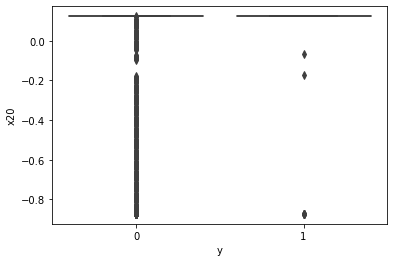

In [35]:
for column in IQR_zero_list:
    print(train_data[column].describe())
    sns.boxplot(x=train_data['y'], y=train_data[column])
    plt.show()

In [36]:
for column in IQR_zero_list:
    train_data[column + '_IQR'] = np.where(train_data[column] > train_data.describe().loc['75%'][column], 1, np.where(train_data[column] < train_data.describe().loc['25%'][column], 1, 0))
    train_data[column + '_IQR'] = train_data[column + '_IQR'].astype("category")
    
    valid_data[column + '_IQR'] = np.where(valid_data[column] > valid_data.describe().loc['75%'][column], 1, np.where(valid_data[column] < valid_data.describe().loc['25%'][column], 1, 0))
    valid_data[column + '_IQR'] = valid_data[column + '_IQR'].astype("category")
    
    column_list.append(column + '_IQR')
    column_list.remove(column)

In [37]:
train_data = train_data.drop(IQR_zero_list, axis=1)
valid_data = valid_data.drop(IQR_zero_list, axis=1)

In [38]:
# numerical data
numeric_column = list(train_data.columns)[2:-(len(many_outlier_list) + len(IQR_zero_list))]

In [39]:
# outlier removal
for column in numeric_column:
    sigma = (train_data.describe().loc['75%'][column] - train_data.describe().loc['25%'][column]) * 100
    upper_limit = train_data.describe().loc['50%'][column] + sigma
    lower_limit = train_data.describe().loc['50%'][column] - sigma

    # train_data = train_data[train_data[column] <= upper_limit][train_data[column] >= lower_limit]

In [40]:
train_data_x = train_data.loc[:, numeric_column]
valid_data_x = valid_data.loc[:, numeric_column]

In [41]:
# skewness 2 이상, kurtosis 3이상인 경우 log 변환 대상으로 처리
skewed_columns = list(train_data_x.loc[:, (abs(train_data_x.skew()) > 2)].columns)
high_kurtosis_columns = list(train_data_x.loc[:, (train_data_x.kurtosis()) > 3].columns)

In [42]:
log_transformation_columns = list(set(skewed_columns + high_kurtosis_columns))
log_transformation_columns

['x11',
 'x30',
 'x9',
 'x49',
 'x39',
 'x41',
 'x10',
 'x25',
 'x32',
 'x7',
 'x40',
 'x58',
 'x46',
 'x18',
 'x8',
 'x15',
 'x45',
 'x12',
 'x14',
 'x37',
 'x16',
 'x59']

In [43]:
## log transformation
for column in log_transformation_columns:
    train_data[column + '_log'] = np.log1p(train_data_x[column] + abs(train_data_x[column].min()))
    valid_data[column + '_log'] = np.log1p(valid_data_x[column] + abs(train_data_x[column].min()))
    
    column_list.append(column + '_log')
    column_list.remove(column)
    
    train_data = train_data.drop(column, axis=1)
    valid_data = valid_data.drop(column, axis=1)

In [44]:
# valid에서 na 발생 (새로운 outlier)
valid_data.isna().sum().sum()

8

In [45]:
# log 범위를 벗어나는 경우 0으로 처리
valid_data = valid_data.fillna(0)

In [46]:
for column in many_outlier_list:
    del outlier_dict[column]

for column in IQR_zero_list:
    del outlier_dict[column]

for column in log_transformation_columns:
    del outlier_dict[column]

In [47]:
train_data = train_data.loc[:, ['time', 'y'] + column_list]
valid_data = valid_data.loc[:, ['time', 'y'] + column_list]

In [48]:
train_data.iloc[:, 2:].columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x13', 'x17', 'x22', 'x23', 'x24',
       'x26', 'x27', 'x29', 'x31', 'x33', 'x34', 'x35', 'x36', 'x42', 'x44',
       'x47', 'x50', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x60',
       'x19_outlier', 'x21_outlier', 'x38_outlier', 'x48_outlier',
       'x51_outlier', 'x20_IQR', 'x11_log', 'x30_log', 'x9_log', 'x49_log',
       'x39_log', 'x41_log', 'x10_log', 'x25_log', 'x32_log', 'x7_log',
       'x40_log', 'x58_log', 'x46_log', 'x18_log', 'x8_log', 'x15_log',
       'x45_log', 'x12_log', 'x14_log', 'x37_log', 'x16_log', 'x59_log'],
      dtype='object')

In [49]:
# scale 필요
train_data.describe()

,y,x1,x2,x3,x4,x5,x6,x13,x17,x22,...,x46_log,x18_log,x8_log,x15_log,x45_log,x12_log,x14_log,x37_log,x16_log,x59_log
count,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,...,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000,8601.000000
mean,0.006395,-0.053051,0.431125,0.557477,-73.595266,-0.338314,-4.558568,1.780001,-0.982229,-0.582834,...,1.221177,1.808231,0.351215,0.487167,1.224082,3.131238,0.050201,0.942365,3.014111,4.607695
std,0.079715,0.736014,5.094969,5.223486,134.772478,0.383127,35.829418,44.042451,1.012108,0.389419,...,0.186123,0.137173,0.044267,0.023043,0.275316,0.246419,0.139174,0.096392,0.298156,0.363031
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-86.578254,-117.561630,-6.512555,-1.226466,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.636085,-2.538988,-2.881269,-175.987130,-0.600642,-41.821312,-28.499463,-1.528791,-0.954711,...,1.105162,1.786458,0.329323,0.474530,1.090341,3.135953,0.000000,0.908318,3.017309,4.626641
50%,0.000000,0.054369,-0.220881,0.146366,-111.287000,-0.336283,6.134957,-7.926404,-0.858808,-0.407284,...,1.207880,1.786458,0.350611,0.487140,1.201234,3.144108,0.000000,0.943856,3.040435,4.632770
75%,0.000000,0.461914,2.444185,2.894360,21.025550,-0.078288,21.693611,38.449191,-0.527784,-0.230342,...,1.318910,1.870327,0.371666,0.500558,1.314651,3.175636,0.105530,0.978289,3.075136,4.645446
max,1.000000,1.705746,16.734899,15.881512,276.493842,1.008428,68.886910,143.876437,3.240767,0.381213,...,2.568408,2.237954,0.695632,0.580762,3.745343,3.297213,1.107961,1.160023,3.122037,4.678116


In [50]:
### for ML models

In [51]:
# remove time data

notime_train_data = train_data.drop(['time'], axis=1)
notime_valid_data = valid_data.drop(['time'], axis=1)

In [52]:
# extract y from data
x_train = notime_train_data.drop(target, axis=1)
x_val = notime_valid_data.drop(target, axis=1)

y_train = notime_train_data.loc[:,target]
y_val = notime_valid_data.loc[:,target]

In [53]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((8601, 58), (8601,), (3555, 58), (3555,))

In [54]:
scaler = RobustScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

In [55]:
x_train_s_df = pd.DataFrame(x_train_s, columns = list(x_train.columns))
x_val_s_df = pd.DataFrame(x_val_s, columns = list(x_val.columns))

In [56]:
for column in x_train_s_df.columns:
    if ('_IQR' in column) or ('_outlier' in column):
        x_train_s_df[column] = x_train_s_df[column].astype(int).astype("category")
        x_val_s_df[column] = x_val_s_df[column].astype(int).astype("category")

## Business tables

In [57]:
co = 100
m = 3
bv = np.array([[0, m],[co, m]])
bv

array([[  0,   3],
       [100,   3]])

In [58]:
base_cost = co * valid_data['time'][valid_data.y==1].count()
base_cost

2500

In [59]:
def calculate_cost(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds, 1, 0)
    
    return (confusion_matrix(y, pred_temp) * bv).sum()

In [60]:
def cost_curve(y_val, val_score, thresholds):
    cost_list = list()
    for thre in thresholds:
        cost_list.append(calculate_cost(y_val, val_score, thre))

    cost_list = np.array(cost_list)

    # 그래프 그리기
    plt.figure(figsize = (10,6))
    plt.plot(thresholds, cost_list, label = 'cost')

    #-------------------------------------------------------------------------
    # 아래 코드는 차트 꾸미기 입니다. 
    thre = round(thresholds[np.argmin(cost_list)], 4)
    cost = round(min(cost_list), 4)
    plt.axvline(thre , color = 'darkred', linewidth = .7)
    plt.axhline(cost, color = 'darkred', linewidth = .7)

    plt.xlabel('Anomaly Score')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid()
    plt.show()
    
    return thre, cost

## Isolation Forest

In [61]:
model1 = IsolationForest()
model1.fit(x_train_s_df)
pred1 = model1.predict(x_val_s_df)
pred1 = np.where(pred1 == 1, 0, 1)
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

[[1770 1760]
 [  13   12]]
              precision    recall  f1-score   support

           0       0.99      0.50      0.67      3530
           1       0.01      0.48      0.01        25

    accuracy                           0.50      3555
   macro avg       0.50      0.49      0.34      3555
weighted avg       0.99      0.50      0.66      3555



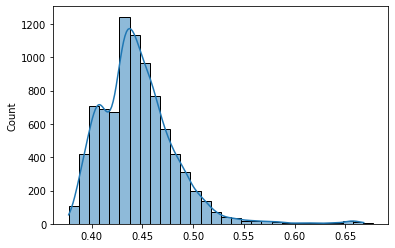

In [62]:
train_score = model1.score_samples(x_train_s_df)
train_score = -1 * train_score 

sns.histplot(train_score, kde=True, binwidth=0.01)
plt.show()

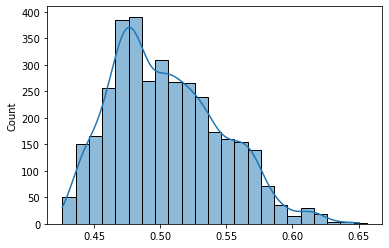

In [63]:
val_score = model1.score_samples(x_val_s_df)
val_score = -1 * val_score

sns.histplot(val_score, kde=True, binwidth=0.01)
plt.show()

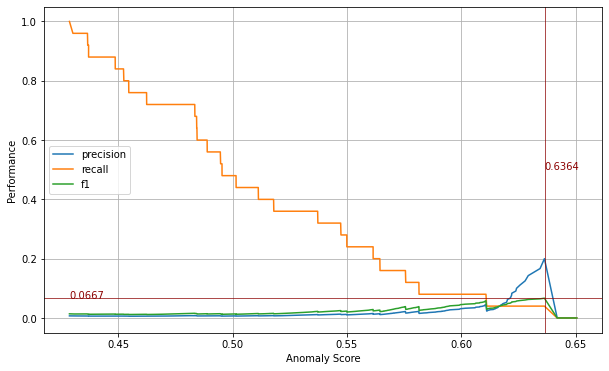

In [64]:
_, _, f1, thresholds = prec_rec_f1_curve(y_val, val_score)

In [65]:
cutoff_f1max = thresholds[np.argmax(f1)]
cutoff_f1max

0.6363639466024675

In [66]:
f1.max()

0.06666666666666667

In [67]:
new_cont = sum(train_score >= cutoff_f1max) / len(train_score)
new_cont

0.004534356470177886

In [68]:
n_est = list(range(20,201,20))
max_s = list(range(100,1001,100))
items = [n_est, max_s]
params = list(product(*items))

In [69]:
f1_list = []

for p in tqdm(params) :
    model = IsolationForest(contamination=new_cont, n_estimators=p[0], max_samples=p[1], random_state=0)
    model.fit(x_train_s_df)
    pred = model.predict(x_val_s_df)
    pred = np.where(pred==1, 0, 1)
    f1_list.append(f1_score(y_val, pred, pos_label=1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


In [70]:
max_id = np.argmax(f1_list)

print(params[max_id])
print(f1_list[max_id])

(40, 800)
0.06896551724137932


In [71]:
model1 = IsolationForest(contamination=new_cont, n_estimators=params[max_id][0], max_samples=params[max_id][1], random_state=0)
model1.fit(x_train_s_df)

pred1 = model1.predict(x_val_s_df)
pred1 = np.where(pred1==1, 0, 1)
print(confusion_matrix(y_val, pred1))
print(classification_report(y_val, pred1))

[[3527    3]
 [  24    1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3530
           1       0.25      0.04      0.07        25

    accuracy                           0.99      3555
   macro avg       0.62      0.52      0.53      3555
weighted avg       0.99      0.99      0.99      3555



In [72]:
train_score = model1.score_samples(x_train_s_df)
train_score = -1 * train_score

val_score = model1.score_samples(x_val_s_df)
val_score = -1 * val_score

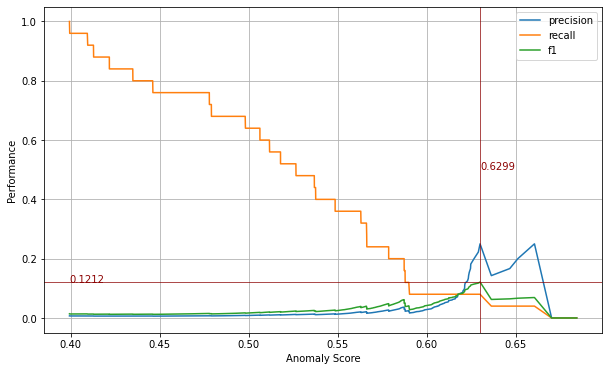

In [73]:
_, _, f1, thresholds = prec_rec_f1_curve(y_val, val_score)

In [74]:
cutoff_f1max = thresholds[np.argmax(f1)]
cutoff_f1max

0.6299236745803396

In [75]:
f1.max()

0.12121212121212122

<AxesSubplot:xlabel='time'>

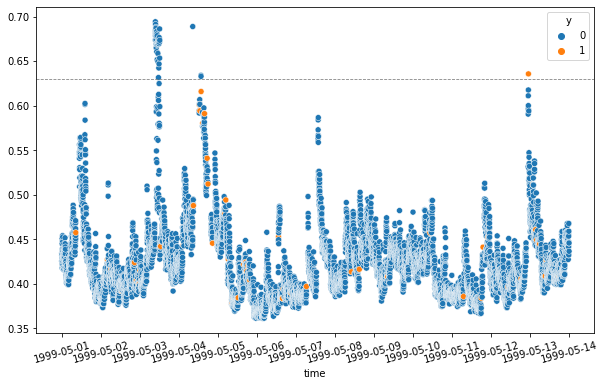

In [76]:
plt.figure(figsize=(10,6))

ax = plt.axes()            
plt.xticks(rotation=15)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.axhline(cutoff_f1max, color='grey', linestyle='--', linewidth=0.8)

sns.scatterplot(train_data['time'], train_score, hue=y_train, ax=ax)

<AxesSubplot:xlabel='time'>

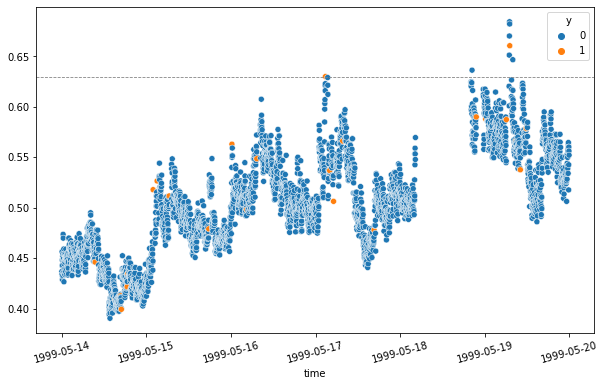

In [77]:
plt.figure(figsize=(10,6))

ax = plt.axes()            
plt.xticks(rotation=15)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.axhline(cutoff_f1max, color='grey', linestyle='--', linewidth=0.8)

sns.scatterplot(valid_data['time'], val_score, hue=y_val, ax=ax)

In [78]:
pred_y = np.where(val_score >= cutoff_f1max, 1, 0)
print(confusion_matrix(y_val, pred_y))

[[3524    6]
 [  23    2]]


In [79]:
cm = confusion_matrix(y_val, pred_y)

In [80]:
base_cost - (cm * bv).sum()

176

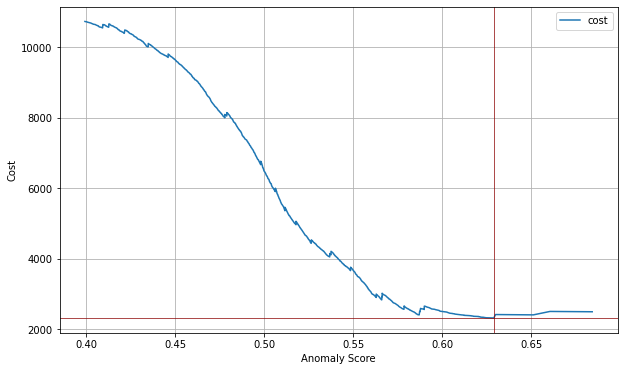

In [81]:
thre1, cost1 = cost_curve(y_val, val_score, thresholds)

In [82]:
pred_y = np.where(val_score >= thre1, 1, 0)
print(confusion_matrix(y_val, pred_y))

[[3523    7]
 [  23    2]]


In [83]:
# best f1의 threshold와 유사
thre1, cost1

(0.6289, 2324)

In [84]:
base_cost - cost1

176

## OneClass SVM

In [85]:
y_train = y_train.reset_index(drop=True)

In [86]:
x_train0 = x_train_s_df[y_train == 0]

In [87]:
model2 = OneClassSVM()
model2.fit(x_train0)
pred2 = model2.predict(x_val_s)
pred2 = np.where(pred2==1, 0, 1) # -1, 1 ==> 1, 0

In [88]:
print(confusion_matrix(y_val, pred2))
print('-'*50)
print(classification_report(y_val, pred2))

[[ 222 3308]
 [   5   20]]
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.06      0.12      3530
           1       0.01      0.80      0.01        25

    accuracy                           0.07      3555
   macro avg       0.49      0.43      0.07      3555
weighted avg       0.97      0.07      0.12      3555



In [89]:
f1_score(y_val, pred2)

0.011929615269907545

In [90]:
nu = [0.001, 0.01, 0.05, 0.1]
gamma = [0.01, 0.1, 0.5, 1]
items = [nu, gamma] 
params = list(product(*items))

In [91]:
f1_list = []
for p in tqdm(params) :
    model=OneClassSVM(nu=p[0], gamma=p[1])
    model.fit(x_train0)
    
    pred = model.predict(x_val_s)
    pred = np.where(pred==1, 0, 1)
    f1_list.append(f1_score(y_val, pred, pos_label=1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:10<00:00,  8.14s/it]


In [92]:
max_id = np.argmax(f1_list)

print(params[max_id])
print(f1_list[max_id])

(0.1, 0.1)
0.014018691588785048


In [93]:
model2 = OneClassSVM(nu=params[max_id][0], gamma=params[max_id][1])
model2.fit(x_train0)

pred2 = model2.predict(x_val_s)
pred2 = np.where(pred2 == 1, 0, 1)

cm = confusion_matrix(y_val, pred2)
print(cm)
print(classification_report(y_val, pred2))

[[ 155 3375]
 [   1   24]]
              precision    recall  f1-score   support

           0       0.99      0.04      0.08      3530
           1       0.01      0.96      0.01        25

    accuracy                           0.05      3555
   macro avg       0.50      0.50      0.05      3555
weighted avg       0.99      0.05      0.08      3555



In [94]:
cost_list = []
for p in tqdm(params) :
    model=OneClassSVM(nu=p[0], gamma=p[1])
    model.fit(x_train0)
    
    pred = model.predict(x_val_s)
    pred = np.where(pred==1, 0, 1)
    cm = confusion_matrix(y_val, pred)
    cost_list.append((cm * bv).sum())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:09<00:00,  8.08s/it]


In [95]:
min_id = np.argmin(cost_list)

print(params[min_id])
print(cost_list[min_id])

(0.001, 0.01)
8732


In [96]:
model2 = OneClassSVM(nu=params[min_id][0], gamma=params[min_id][1])
model2.fit(x_train0)

pred2 = model2.predict(x_val_s)
pred2 = np.where(pred2==1, 0, 1)

cm = confusion_matrix(y_val, pred2)
print(cm)
print(classification_report(y_val, pred2))

[[ 903 2627]
 [   8   17]]
              precision    recall  f1-score   support

           0       0.99      0.26      0.41      3530
           1       0.01      0.68      0.01        25

    accuracy                           0.26      3555
   macro avg       0.50      0.47      0.21      3555
weighted avg       0.98      0.26      0.40      3555



In [97]:
# 오히려 손해 남..
base_cost - cost_list[min_id]

-6232

## LSTM-AE

In [98]:
# extract y from data
x_train = train_data.drop(target, axis=1)
x_val = valid_data.drop(target, axis=1)

y_train = train_data.loc[:,target]
y_val = valid_data.loc[:,target]

In [99]:
seq_size = 3
drop_list = ['time']

scaler = RobustScaler()
scaler.fit_transform(x_train.drop('time', axis=1)[y_train==0])

def drop_columns(data):
    for column in drop_list:
        if column in data.columns:
            data = data.drop(column, axis=1)
            
    return data

def to_sequences(data, target, train=False): # Number of time steps to look back
    sub_df_list = get_sub_df(data)
            
    # sub-dataframe seq 전환
    for i, sub_df in enumerate(sub_df_list):
        if len(sub_df) < seq_size:
            continue
            
        # 컬럼 제거
        sub_df = drop_columns(sub_df)
        
        if train:
            sub_df = sub_df[sub_df[target]==0]
            
        x = sub_df.drop(target, axis=1)
        x_scale = scaler.transform(x)

        y = sub_df[target]

        seq_x, seq_y = temporalize(x_scale, list(y), seq_size)
            
        if i==0:
            total_seq_x = seq_x
            total_seq_y = seq_y
        else:
            try:
                total_seq_x = np.append(total_seq_x, seq_x, axis=0)
                total_seq_y = np.append(total_seq_y, seq_y, axis=0)

            except ValueError as e:
                print(e)

    return total_seq_x, total_seq_y

In [100]:
x_seq, y_seq = to_sequences(train_data, 'y', train=True)

all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)
all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)


In [101]:
x_seq_val, y_seq_val = to_sequences(valid_data, 'y')

In [102]:
n_features =  x_seq.shape[2]

In [103]:
clear_session()

# Encoder - Decoder
model3 = Sequential([LSTM(128, input_shape = (seq_size, n_features), return_sequences=True),
                     LSTM(64, return_sequences=False),
                     RepeatVector(seq_size),
                     LSTM(64, return_sequences=True),
                     LSTM(128, return_sequences=True),
                     TimeDistributed(Dense(n_features))])

# input_layer = Input(shape=(timesteps, n_features))
# encoder = LSTM(128, return_sequences=True)(input_layer)
# encoder = LSTM(64, return_sequences=False)(encoder)
# encoder = RepeatVector(timesteps)(encoder)

# # Decoder
# decoder = LSTM(64, return_sequences=True)(encoder)
# decoder = LSTM(128, return_sequences=True)(decoder)
# decoder = TimeDistributed(Dense(n_features))(decoder)
# lstm_ae = Model(inputs=input_layer, outputs=decoder)

model3.summary()

2023-06-26 12:55:57.407853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 128)            95744     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            98816     
                                                                 
 time_distributed (TimeDistr  (None, 3, 58)            7482      
 ibuted)                                                

In [104]:
model3.compile(optimizer='adam', loss = 'mse')
model3.fit(x_seq, x_seq, epochs=10, batch_size=5, verbose=1)

Epoch 1/10
1690/1690 [==============================] - 42s 20ms/step - loss: 203.1196
Epoch 2/10
1690/1690 [==============================] - 28s 17ms/step - loss: 185.2843
Epoch 3/10
1690/1690 [==============================] - 28s 17ms/step - loss: 170.5947
Epoch 4/10
1690/1690 [==============================] - 29s 17ms/step - loss: 158.4158
Epoch 5/10
1690/1690 [==============================] - 24s 14ms/step - loss: 145.4281
Epoch 6/10
1690/1690 [==============================] - 24s 14ms/step - loss: 133.8281
Epoch 7/10
1690/1690 [==============================] - 24s 14ms/step - loss: 123.5082
Epoch 8/10
1690/1690 [==============================] - 28s 17ms/step - loss: 115.3216
Epoch 9/10
1690/1690 [==============================] - 25s 15ms/step - loss: 106.3193
Epoch 10/10
1690/1690 [==============================] - 24s 14ms/step - loss: 101.5769


In [105]:
pred3 = model3.predict(x_seq_val)

110/110 [==============================] - 3s 11ms/step


In [106]:
result1 = get_recon_err(x_seq_val, pred3, y_seq_val)

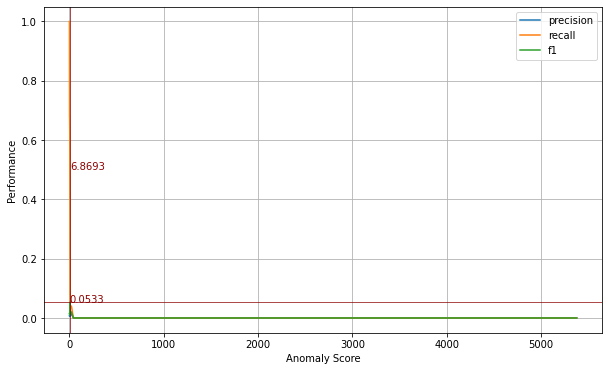

In [107]:
_, _, f1, thresholds = prec_rec_f1_curve(result1['True_class'], result1['Recon_error'])

In [108]:
thresholds[np.argmax(f1)], max(f1)

(6.869335937723204, 0.05333333333333334)

In [109]:
thre = thresholds[np.argmax(f1)]
cm = get_confusion_matrix(result1['True_class'], result1['Recon_error'], thre)
classification_report_with_cm(result1['True_class'], result1['Recon_error'], thre)

< confusion matrix >

[[3292  194]
 [  20    5]]


< classification_report >

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3486
           1       0.03      0.20      0.04        25

    accuracy                           0.94      3511
   macro avg       0.51      0.57      0.51      3511
weighted avg       0.99      0.94      0.96      3511



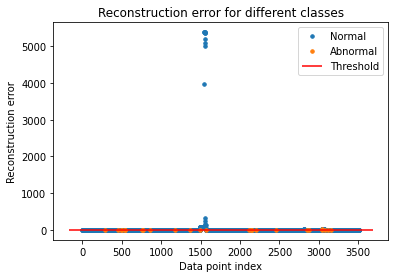

In [110]:
recon_err_plot(result1, thre)

In [111]:
max(f1)

0.05333333333333334

In [112]:
thre

6.869335937723204

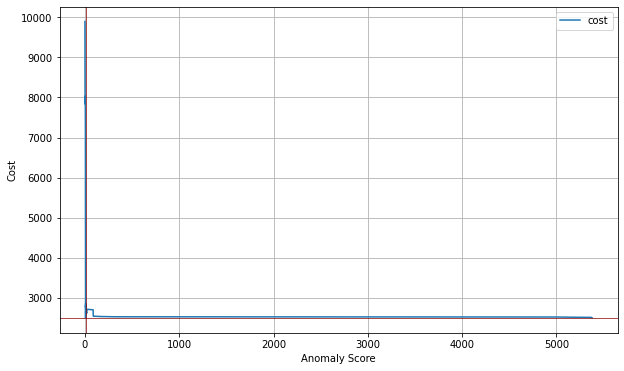

In [113]:
thre3, cost3 = cost_curve(result1['True_class'], result1['Recon_error'], thresholds)

In [114]:
calculate_cost(result1['True_class'], result1['Recon_error'], thresholds[np.argmax(f1)])

2597

In [115]:
thre3, cost3

(6.8647, 2500)

In [116]:
classification_report_with_cm(result1['True_class'], result1['Recon_error'], thre3)

< confusion matrix >

[[3292  194]
 [  19    6]]


< classification_report >

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3486
           1       0.03      0.24      0.05        25

    accuracy                           0.94      3511
   macro avg       0.51      0.59      0.51      3511
weighted avg       0.99      0.94      0.96      3511



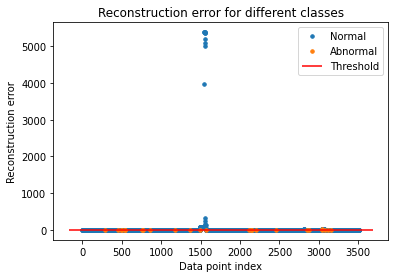

In [117]:
recon_err_plot(result1, thre3)

In [118]:
base_cost - cost3

0

## CNN-AE

In [119]:
timesteps =  x_seq.shape[1] # equal to the lookback
n_features =  x_seq.shape[2] # 52
n_features

58

In [120]:
clear_session()

model4 = Sequential([Conv1D(32, 3, input_shape=(timesteps, n_features), 
                                activation='relu', padding = 'same'), 
                        Conv1D(16, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(16, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(32, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(n_features, 3, padding = 'same') ])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             5600      
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 16)             1552      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 3, 16)            784       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 3, 32)            1568      
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 3, 58)            5626      
 ranspose)                                                       
                                                        

In [121]:
model4.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')
model4.fit(x=x_seq, y=x_seq, epochs=10)

Epoch 1/10
264/264 [==============================] - 2s 7ms/step - loss: 97.1679
Epoch 2/10
264/264 [==============================] - 3s 12ms/step - loss: 15.0291
Epoch 3/10
264/264 [==============================] - 2s 6ms/step - loss: 2.2928
Epoch 4/10
264/264 [==============================] - 2s 7ms/step - loss: 1.5977
Epoch 5/10
264/264 [==============================] - 2s 6ms/step - loss: 1.6902
Epoch 6/10
264/264 [==============================] - 2s 6ms/step - loss: 1.9372
Epoch 7/10
264/264 [==============================] - 2s 6ms/step - loss: 2.6924
Epoch 8/10
264/264 [==============================] - 2s 6ms/step - loss: 1.0208
Epoch 9/10
264/264 [==============================] - 2s 6ms/step - loss: 3.2635
Epoch 10/10
264/264 [==============================] - 2s 6ms/step - loss: 9.3263


In [122]:
pred4 = model4.predict(x_seq_val)

110/110 [==============================] - 1s 3ms/step


In [123]:
result2 = get_recon_err(x_seq_val, pred4, y_seq_val)

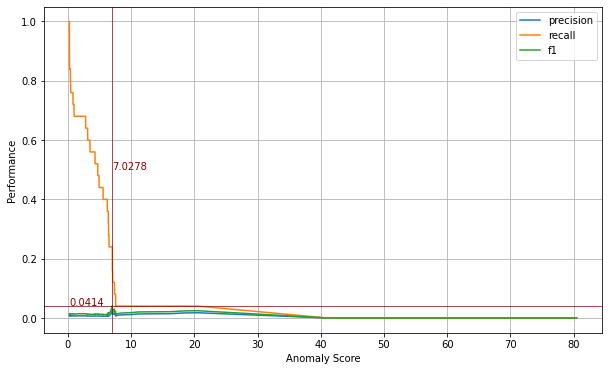

In [124]:
_, _, f1, thresholds = prec_rec_f1_curve(result2['True_class'], result2['Recon_error'])

In [125]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

7.0277594646600665

In [126]:
thre = thresholds[np.argmax(f1)]
classification_report_with_cm(result2['True_class'], result2['Recon_error'], thre)

< confusion matrix >

[[3227  259]
 [  20    5]]


< classification_report >

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3486
           1       0.02      0.20      0.03        25

    accuracy                           0.92      3511
   macro avg       0.51      0.56      0.50      3511
weighted avg       0.99      0.92      0.95      3511



In [127]:
max(f1)

0.041379310344827586

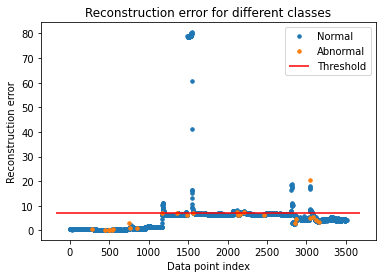

In [128]:
recon_err_plot(result2, thre)

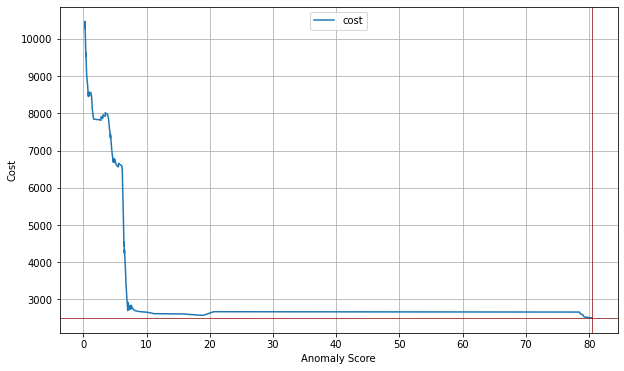

In [129]:
thre4, cost4 = cost_curve(result2['True_class'], result2['Recon_error'], thresholds)

In [130]:
thre4, cost4

(80.4869, 2500)

In [131]:
classification_report_with_cm(result2['True_class'], result2['Recon_error'], thre4)

< confusion matrix >

[[3485    1]
 [  25    0]]


< classification_report >

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3486
           1       0.00      0.00      0.00        25

    accuracy                           0.99      3511
   macro avg       0.50      0.50      0.50      3511
weighted avg       0.99      0.99      0.99      3511



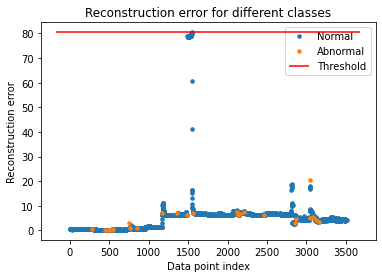

In [132]:
recon_err_plot(result2, thre4)

In [133]:
base_cost - cost4

0